# Projekt 1 - KM3
Zbiór danych nr 3: https://www.apispreadsheets.com/datasets/122

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline, make_pipeline
import shap

from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier, plot_tree

import scipy.stats
import joblib

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin/'

plt.rcParams['figure.figsize'] = (16,6)
sns.set(font_scale = 1.1)
sns.set_style("ticks",{'axes.grid' : True})
sns.set_palette("deep")

### Przypomnienie
Zmienna docelowa przyjmuje sześć kategorii, czyli liczby od 1 do 6, które możemy tłumaczyć jako kolejne aktywności człowieka:
* WALKING
* WALKING_UPSTAIRS
* WALKING_DOWNSTAIRS
* SITTING
* STANDING
* LAYING

### Podsumowanie po KM2
Osiągnęliśmy bardzo dobre rezultaty w wypróbowanych modelach. Objawiały się podobne problemy w klasyfikacji, głównie między klasami $4$ i $5$, a także pojedyncze błędy przy trzech pierwszych kategoriach. 

Właśnie ze względu na podobieństwo rezultatów zwykły *score* wydaje się najprostszy do wybrania najlepszych modeli. Wygląda to następująco:
* najlepsze wyniki (powyżej 0.98) zostały osiągnięte dla: *LogisticRegression*, *LinearSVC*, *VotingClassifier*, *XGBoost*
* następnie plasują się: 
    * *RandomForestClassifier* (0.97)
    * *KNeighborsClassifier* (0.95)
    * *AdaBoostClassifier* (0.93) 
    * *DecisionTreeClassifier* (0.93)
    * *GradientBoostingClassifier* (0.92)
    * *GaussianNB* (0.85)

#### OutlierCutter
Przycięcie wartości odstających z obu stron na odpowiednim kwantylu. Do sprawdzenia wpływ na wyniki modeli.

In [2]:
class OutlierCutter(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._Q025 = None
        self._Q975 = None
        pass
    
    def fit(self, X, y=None):
        self._Q025 = X.quantile(0.025)
        self._Q975 = X.quantile(0.975)
        return self

    def transform(self, X):
        tmp = X.copy()
        for col in tmp.columns:
            tmp.loc[tmp[col] < self._Q025[col], col] = self._Q025[col]
            tmp.loc[tmp[col] > self._Q975[col], col] = self._Q975[col]
        return tmp

#### Drukowanie raportu

In [3]:
def print_precision_recall_report(clf, X_train, y_train, X_test, y_test):
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    # tabelki precision / recall / f1
    def print_precision_recall_table(y, y_pred, title='Zbiór ...'):
        s = pd.DataFrame(classification_report(
                y, y_pred,
                output_dict = True
            )).iloc[:-1, :-2].to_string(float_format=lambda x: "{:7.4f}".format(x))
        print(title.center(s.index('\n'), '-'))
        print(s)
        print()

    print_precision_recall_table(y_train, y_train_pred, 'Zbiór treningowy')
    print_precision_recall_table(y_test, y_test_pred, 'Zbiór testowy')

    # macierz pomyłek
    def plot_confusion_matrix(y, y_pred, title, ax):
        conf_mx = confusion_matrix(y, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_mx, display_labels=[1, 2, 3, 4, 5, 6])
        disp.plot(colorbar=False, cmap=plt.cm.Blues, ax=ax, values_format='d')
        ax.grid(False)
        ax.set_title(title)
        
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    plot_confusion_matrix(y_train, y_train_pred, 'Zbiór treningowy', axs[0])
    plot_confusion_matrix(y_test, y_test_pred, 'Zbiór testowy', axs[1])
    axs[1].set_ylabel(None)
    plt.show()

### Wczytanie, podział danych
Podział na zbiory: trenigowy, testowy, walidacyjny w proporcji [ (70\% | 30\%) | 30\%].

In [4]:
df = pd.read_csv('smartphone_activity_dataset.csv')
y = df['activity']
X = df.drop('activity', axis=1)

X_train_test, X_val, y_train_test, y_val = train_test_split(X, y, random_state=2137, test_size=0.3, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, random_state=420, test_size=0.3, stratify=y_train_test)

## Optymalizacja hiperparametrów

### Regresja logistyczna
Najlepsze wyniki osiągaliśmy, wykorzystując *lasso* jako metodę regulacji. Spróbujemy teraz znaleźć odpowiednią wartość parametru siły regulacji `C`. Wykorzystamy do tego klasę `LogisticRegressionCV`, która jest specjalnym wariantem `GridSearchCV` przystosowanym do modelu regresji logistycznej.

In [5]:
clf = LogisticRegressionCV(penalty='l1', Cs= np.arange(0.1, 3, 0.1), solver='liblinear', cv=5, random_state=0)
# clf.fit(X_train, y_train)
# joblib.dump(clf, 'models\lr.pkl');
clf = joblib.load('models\lr.pkl');

--------------------------Zbiór treningowy-------------------------
                1       2       3       4       5       6  accuracy
precision  1.0000  1.0000  1.0000  0.9713  0.9732  1.0000    0.9901
recall     1.0000  1.0000  1.0000  0.9713  0.9732  1.0000    0.9901
f1-score   1.0000  1.0000  1.0000  0.9713  0.9732  1.0000    0.9901

---------------------------Zbiór testowy---------------------------
                1       2       3       4       5       6  accuracy
precision  1.0000  0.9908  1.0000  0.9571  0.9624  1.0000    0.9843
recall     0.9945  1.0000  1.0000  0.9571  0.9600  1.0000    0.9843
f1-score   0.9972  0.9954  1.0000  0.9571  0.9612  1.0000    0.9843



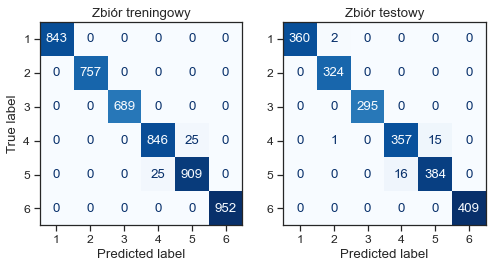

In [6]:
print_precision_recall_report(clf, X_train, y_train, X_test, y_test)

Nasze szukanie parametrów na niewiele się zdało, ponieważ na zbiorze testowym jest tylko o jeden przypadek źle sklasyfikowany mniej.

Dla każdej klasy zostały wyznaczone najlepsze wartości parametru `C`. 

In [7]:
clf.C_

array([2.8, 2.7, 2.7, 0.7, 2. , 1. ])

Z ciekawości możemy sprawdzić, którym kolumny były ignorowane, a którym została przypisana najwyższa waga.

In [8]:
# ile kolumn przy klasyfikacji każdej klasy otrzymało współczynnik abs(coef_) < 0.01
coef = pd.DataFrame(clf.coef_, columns=X.columns, index=[1,2,3,4,5,6])
(np.abs(coef) < 1e-2).sum(axis=1)

1    418
2    388
3    412
4    421
5    392
6    545
dtype: int64

In [9]:
# szukamy kolumn o najwyższych współczynnikach
rows = []

for i in [1,2,3,4,5,6]:
    rows.append(coef.loc[i, :].abs().sort_values(ascending=False).head(3).index)

pd.DataFrame(rows, columns=['1st best', '2nd best', '3rd best'], index=[1,2,3,4,5,6])

,1st best,2nd best,3rd best
1,feature_38,feature_105,feature_199
2,feature_51,feature_103,feature_195
3,feature_90,feature_38,feature_25
4,feature_183,feature_187,feature_446
5,feature_183,feature_54,feature_57
6,feature_53,feature_559,feature_57


#### Podsumowanie
Optymalizacja hiperparametrów nie przyniosła wiele pożytku dla regresji logistycznej. 

Jednak ten model jest bardzo łatwo wyjaśnić. Przy klasyfikacji każdej klasy około 400 zmiennych jest bez znaczenia, a pozostałe 160 uzyskuje bardziej znaczące współczynniki. Wyjątkiem jest kategoria *6*, co do której decyzja może być podjęta przy udziale raptem kilku zmiennych (co zresztą zostało pięknie pokazane podczas eksploracyjnej analizy danych). 

Ponadto możemy zobaczyć, które zmienne są najważniejsze dla danej klasy. I tak na przykład `feature_53`, któremu model przyznał najwyższą wagę dla kategorii *6*, został już zauważony już podczas ekploracji. Utwierdza nas to w przekonaniu, że decyzje podejmowane przez model logiczne i wytłumaczalne.

### Linear Support Vector Classification

In [10]:
svc = RandomizedSearchCV(
    LinearSVC(dual=False, random_state=0, max_iter=200),  
    {
        'C': scipy.stats.uniform(loc=0, scale=4),
        'penalty': ['l2', 'l1'],
    }, 
    random_state=0, 
    n_iter=100)
# clf.fit(X_train, y_train)
# joblib.dump(clf, 'models\svc.pkl');
svc = joblib.load('models\svc.pkl');

--------------------------Zbiór treningowy-------------------------
                1       2       3       4       5       6  accuracy
precision  1.0000  1.0000  1.0000  0.9692  0.9763  1.0000    0.9903
recall     1.0000  1.0000  1.0000  0.9747  0.9711  1.0000    0.9903
f1-score   1.0000  1.0000  1.0000  0.9720  0.9737  1.0000    0.9903

---------------------------Zbiór testowy---------------------------
                1       2       3       4       5       6  accuracy
precision  1.0000  0.9938  0.9966  0.9598  0.9649  1.0000    0.9852
recall     0.9972  0.9969  1.0000  0.9598  0.9625  1.0000    0.9852
f1-score   0.9986  0.9954  0.9983  0.9598  0.9637  1.0000    0.9852



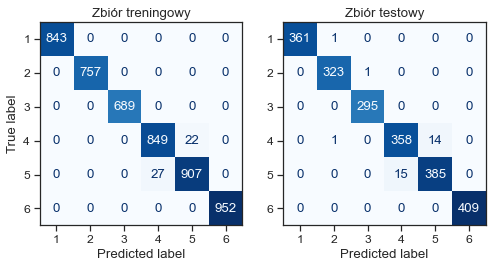

In [11]:
print_precision_recall_report(svc, X_train, y_train, X_test, y_test)

In [12]:
svc.best_params_

{'C': 0.3694955578435928, 'penalty': 'l1'}

In [13]:
# ile kolumn przy klasyfikacji każdej klasy otrzymało współczynnik abs(coef_) < 0.01
coef = pd.DataFrame(svc.best_estimator_.coef_, columns=X.columns, index=[1,2,3,4,5,6])
(np.abs(coef) < 1e-2).sum(axis=1)

1    477
2    430
3    472
4    382
5    390
6    550
dtype: int64

In [14]:
coef

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_552,feature_553,feature_554,feature_555,feature_556,feature_557,feature_558,feature_559,feature_560,feature_561
1,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,-0.281233,...,0.0,0.232441,0.000000,0.000000,0.000000,-0.032847,-0.058777,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.045428,...,0.0,0.000000,0.221023,0.000000,0.038974,-0.041296,0.009282,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.470172,...,0.0,-0.551953,0.000000,0.000000,0.000000,0.034424,0.000000,0.000000,0.0,0.0
4,0.0,0.0,0.0,-0.175243,0.000000,-0.011751,-0.108067,0.00000,0.0,-0.257954,...,0.0,0.079212,0.000000,0.158095,-0.095617,-0.147570,-0.199490,-1.309791,0.0,0.0
5,0.0,0.0,0.0,-0.012686,-0.471964,0.000000,0.000000,-0.18855,0.0,-0.053925,...,0.0,-0.014231,0.000000,-0.056758,0.059392,0.099349,0.234363,-0.025768,0.0,0.0
6,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


In [15]:
# szukamy kolumn o najwyższych współczynnikach
rows = []

for i in [1,2,3,4,5,6]:
    rows.append(coef.loc[i, :].abs().sort_values(ascending=False).head(3).index)

pd.DataFrame(rows, columns=['1st best', '2nd best', '3rd best'], index=[1,2,3,4,5,6])

,1st best,2nd best,3rd best
1,feature_38,feature_215,feature_202
2,feature_51,feature_103,feature_142
3,feature_38,feature_90,feature_505
4,feature_183,feature_187,feature_446
5,feature_183,feature_54,feature_187
6,feature_57,feature_56,feature_53


#### Podsumowanie
I dla tego modelu poszukiwanie najlepszego zestawu hiperparametrów nie przyniosło oczekiwanych rezultatów. Nie ma żadnej poprawy w osiąganych wynikach.

*Random Search* proponuje nam metodę *lasso* oraz niską wartość parametru `C=0.37`. Oznacza to bardzo silną regulację. Jeszcze więcej kolumn zostało odrzuconych (otrzymało bardzo niskie współczynniki). Natomiast najlepsze zmienne są prawie takie same jak te zwrócone przez regresję logistyczną. Możliwe zatem, że *Linear SVC* będzie się lepiej generalizował niż regresja logistyczna.

In [16]:
coef

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_552,feature_553,feature_554,feature_555,feature_556,feature_557,feature_558,feature_559,feature_560,feature_561
1,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,-0.281233,...,0.0,0.232441,0.000000,0.000000,0.000000,-0.032847,-0.058777,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.045428,...,0.0,0.000000,0.221023,0.000000,0.038974,-0.041296,0.009282,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.470172,...,0.0,-0.551953,0.000000,0.000000,0.000000,0.034424,0.000000,0.000000,0.0,0.0
4,0.0,0.0,0.0,-0.175243,0.000000,-0.011751,-0.108067,0.00000,0.0,-0.257954,...,0.0,0.079212,0.000000,0.158095,-0.095617,-0.147570,-0.199490,-1.309791,0.0,0.0
5,0.0,0.0,0.0,-0.012686,-0.471964,0.000000,0.000000,-0.18855,0.0,-0.053925,...,0.0,-0.014231,0.000000,-0.056758,0.059392,0.099349,0.234363,-0.025768,0.0,0.0
6,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


### XGBoost Classifier

Dla klasyfikatora XGBoost również dostroimy hiperparametry. Spróbujemy znaleźć optymalną maksymalną głębokość drzewa, współczynnik uczenia oraz liczbę estymatorów.

In [17]:
xgb_search = GridSearchCV(
    XGBClassifier(eval_metric = 'merror'),
    {
        'max_depth': [3, 6, 12],
        'learning_rate': [0.1, 0.3, 0.6],
        'n_estimators': [50, 100, 200]
    },
    cv = 3
)
#xgb_search.fit(X_train, y_train - 1)
#joblib.dump(xgb_search, 'search/xgb_search.pkl')
xgb_search = joblib.load('search/xgb_search.pkl')

Najlepsze wyniki przedstawiają się następująco:

In [18]:
xgb_results = pd.DataFrame(xgb_search.cv_results_['params']).assign(score = xgb_search.cv_results_['mean_test_score'])
xgb_results.sort_values(by = 'score', ascending = False).head(5)

,learning_rate,max_depth,n_estimators,score
11,0.3,3,200,0.982759
10,0.3,3,100,0.982759
2,0.1,3,200,0.981966
20,0.6,3,200,0.981768
19,0.6,3,100,0.981371


W ogólnym przypadku poszczególne parametry sprawdziły się następująco:

In [19]:
xgb_results.groupby('max_depth')['score'].mean().to_frame()

,score
max_depth,
3,0.980006
6,0.978575
12,0.976395


In [20]:
xgb_results.groupby('n_estimators')['score'].mean().to_frame()

,score
n_estimators,
50,0.975955
100,0.978971
200,0.980050


Spróbujemy więc jeszcze zwiększyć liczbę estymatorów (widzimy bowiem, że wraz z ich większą liczbą rośnie dokładność modelu), a także dobrać dokładniejszą wartość parametru `max_depth`.

In [21]:
xgb_search_2 = GridSearchCV(
    XGBClassifier(eval_metric = 'merror'),
    {
        'max_depth': [2, 3, 4],
        'n_estimators': [200, 400, 800]
    },
    cv = 3
)
#xgb_search_2.fit(X_train, y_train - 1)
#joblib.dump(xgb_search_2, 'search/xgb_search_2.pkl')
xgb_search_2 = joblib.load('search/xgb_search_2.pkl')

In [22]:
xgb_search_2.best_params_

{'max_depth': 2, 'n_estimators': 800}

Nasze przypuszczenia potwierdziły się - ponownie najwyższą dokładność uzyskaliśmy dla największej wartości `n_estimators`.

Sprawdźmy dokładność modelu na zbiorze testowym.

--------------------------Zbiór treningowy-------------------------
                1       2       3       4       5       6  accuracy
precision  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000    1.0000
recall     1.0000  1.0000  1.0000  1.0000  1.0000  1.0000    1.0000
f1-score   1.0000  1.0000  1.0000  1.0000  1.0000  1.0000    1.0000

---------------------------Zbiór testowy---------------------------
                1       2       3       4       5       6  accuracy
precision  0.9972  0.9908  1.0000  0.9678  0.9724  1.0000    0.9875
recall     0.9972  1.0000  0.9932  0.9678  0.9700  1.0000    0.9875
f1-score   0.9972  0.9954  0.9966  0.9678  0.9712  1.0000    0.9875



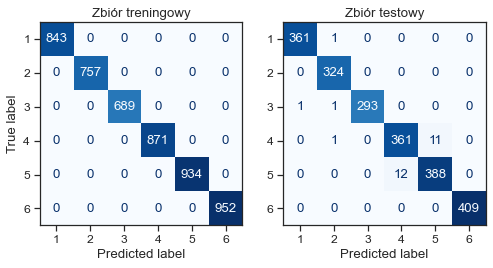

In [23]:
xgb = XGBClassifier(eval_metric = 'merror', max_depth = 2, n_estimators = 800, learning_rate = 0.3, use_label_encoder=True)
#xgb.fit(X_train, y_train)
#joblib.dump(xgb, 'models/xgb.pkl')
xgb = joblib.load('models/xgb.pkl')
print_precision_recall_report(xgb, X_train, y_train, X_test, y_test)

Udało nam się nieznacznie poprawić wyniki regresji logistycznej i SVC. Model uzyskał $100\%$ dokładności na zbiorze treningowym i bynajmniej nie został przetrenowany, albowiem uzyskaliśmy również bardzo wysoką dokładność na zbiorze testowym - $98,75\%$.

### Voting Classifier

Mamy już trzy znakomicie spisujące się klasyfikatory; spróbujemy więc jeszcze „na deser” połączyć wszystkie najlepsze cechy każdego z nich przy pomocy głosowania miękkiego.

In [24]:
estimators = [
    ('lr', LogisticRegressionCV(penalty='l1', Cs=[2.8, 2.7, 2.7, 0.7, 2., 1.], solver='liblinear')),
    ('svc', SVC(kernel='linear', probability=True, random_state=0, max_iter=200, C=0.3694955578435928)),
    ('xgb', XGBClassifier(eval_metric = 'merror', max_depth = 2, n_estimators = 800, learning_rate = 0.3, use_label_encoder=True)),
]

In [25]:
vot = VotingClassifier(estimators = estimators, voting = 'soft')
#vot.fit(X_train, y_train)
#joblib.dump(vot, 'models/vot.pkl')
vot = joblib.load('models/vot.pkl')

--------------------------Zbiór treningowy-------------------------
                1       2       3       4       5       6  accuracy
precision  1.0000  1.0000  1.0000  0.9931  0.9915  1.0000    0.9972
recall     1.0000  1.0000  1.0000  0.9908  0.9936  1.0000    0.9972
f1-score   1.0000  1.0000  1.0000  0.9920  0.9925  1.0000    0.9972

---------------------------Zbiór testowy---------------------------
                1       2       3       4       5       6  accuracy
precision  1.0000  0.9939  1.0000  0.9706  0.9749  1.0000    0.9894
recall     0.9972  1.0000  0.9966  0.9732  0.9725  1.0000    0.9894
f1-score   0.9986  0.9969  0.9983  0.9719  0.9737  1.0000    0.9894



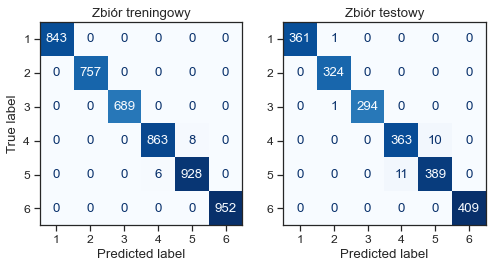

In [26]:
print_precision_recall_report(vot, X_train, y_train, X_test, y_test)

Głosowanie miękkie przyniosło pożądany efekt - przebiliśmy wyniki z trzech poprzednich modeli, a uzyskana dokładność na zbiorze testowym to niemal $99\%$.

## Interpretacja modeli liniowych
Dwa powyższe modele - regresja logistyczna oraz support vector classifier z jądrem liniowym - mają tą szczególną właściwość, że bardzo dobrze możemy przyjrzeć się, dlaczego taka, a nie inna decyzja została podjęta. Pokażemy to na przykładzie klasy `4` i `5`, z których to klasyfikacją są największe problemy.

Na początku jeszcze warto wyjaśnić, na jakiej zasadzie jest podejmowana decyzja o przynależności do danej kategorii. W powyższych modelach stosowane jest podejście *one-vs-rest*. Mamy 6 klas, więc pod spodem mamy 6 klasyfikatorów, każdy podejmuje decyzję, z jakim prawdopodobieństwem ta obserwacja to klasa `i`-ta (albo nie klasa `i`-ta). Decyzja finalna to decyzja najbardziej pewnego klasyfikatora, który twierdzi, że ta obserwacja należy do niego. Dlatego też dla każdej klasy docelowej mamy osobny wektor współczynników (*coefficents*) czy prawdopodobieństw.

Spójrzmy na wykresy zależności od `feature_183` i `feature_187`. Te zmienne otrzymały najwyższe współczynniki, jeśli chodzi o klasy `4` i `5`. 

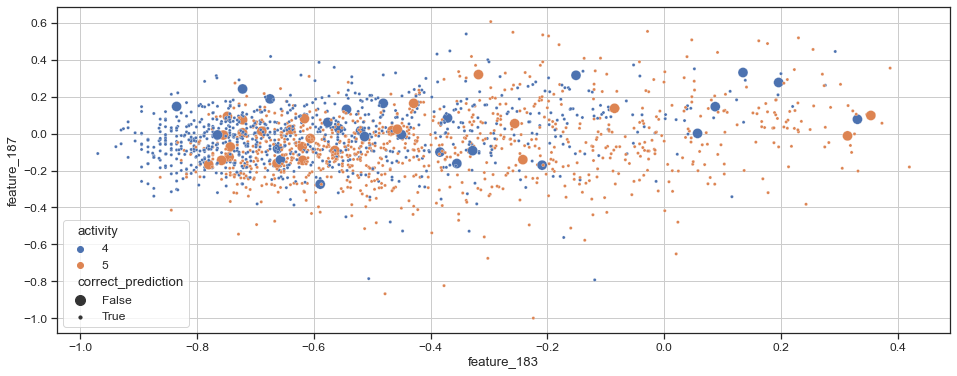

In [27]:
tmp = pd.concat([X_train, y_train], axis=1)
tmp = tmp.loc[tmp['activity'].isin([4, 5]), :]
tmp['predicted_activity'] = clf.predict(tmp.drop('activity', axis=1))
tmp['correct_prediction'] = tmp['activity'] == tmp['predicted_activity']
sns.scatterplot(data=tmp, x='feature_183', y='feature_187', hue='activity', size='correct_prediction', sizes=(10, 100), palette="deep")
plt.show()

Jak można wyło się spodziewać, nic nie widać. Te współczynniki są ważne przy **obu** klasach `4` i `5`, więc nie pozwolą nam dobrze między nimi rozróżniać. 

Spróbujmy wyjaśnić, dlaczego obserwacje z faktycznej klasy `4` otrzymały predykcję klasy `5`. Poszukajmy współczynników, które się maksymalnie różnią dla tych klas.

In [28]:
# zmienne, które otrzymały skrajnie różne współczynniki dla klas 4 i 5
coef = pd.DataFrame(clf.coef_, columns=X.columns, index=[1,2,3,4,5,6])
(coef.loc[5, :].abs() - coef.loc[4, :].abs()).abs().sort_values(ascending=False).head(5)

feature_57     8.257451
feature_54     6.929069
feature_183    4.115721
feature_559    3.921554
feature_122    3.555175
dtype: float64

Zobaczmy zatem, jak wygląda predykcja klasy docelowej w zależności od `feature_57` i `feature_54`.

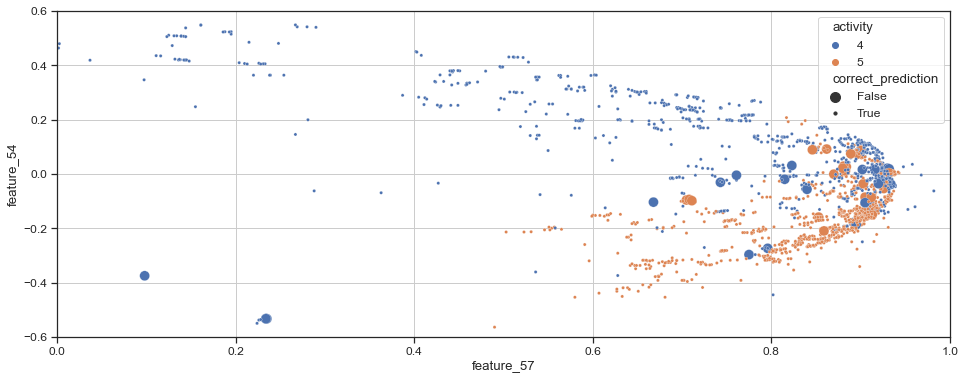

In [29]:
sns.scatterplot(data=tmp, x='feature_57', y='feature_54', hue='activity', size='correct_prediction', sizes=(10, 100), palette="deep")
plt.xlim([0, 1])
plt.ylim([-0.6, 0.6])
plt.show()

Na tym wykresie widać już jasny podział pomiędzy klasami docelowymi. Duże niebieskie piłeczki to obserwacje faktycznej klasy `4`, które model predykuje, że należą do klasy `5`. Widzimy, że te duże niebieskie piłeczki leżą głównie na terenach zajmowanych przez punkty pomarańczowe. Podobnie duże piłeczki pomarańczowe (klasa `5` spredykowana jako `4`) - leżą na terenach niebieskich.

#### Wnioski
Modele liniowe są wyjaśnialne. Na podstawie współczynników przydzielonych przez model jesteśmy w stanie dojść do zmiennych, które decydują o przynależności dla danej klasy.

Szukaliśmy zmiennych, na podstawie których model decyduje o podziale między klasami `4` i `5`. Znaleźliśmy je, są to między innymi `feature_54` i `feature_57`. Podział między klasami `4` i `5` widać na wykresie gołym okiem. Ponadto zobaczyliśmy, dlaczego występuje tak dużo błędów w klasyfikacji. Zmienne (wskaźniki telefonu) przyjmują wartości, które jakby śwadczą o przynależności do tej drugiej klasy i zwodzą model.

## Interpretacja modelu XGBoost

Model wzmacniania gradientowego (którego implementację zawiera `XGBoost`), a także wykorzystujący m.in. właśnie jego predykcje model głosowania miękkiego, są tzw. modelami czarnej skrzynki, a zatem, choć osiągamy dzięki nim bardzo dokładne przewidywania, to jednak trudno jest na pierwszy rzut oka wyjaśnić, skąd w konkretnym przypadku wzięła się taka, a nie inna prognoza. Niemniej dysponujemy kilkoma pomocniczymi narzędziami, które pomogą nam w dokonaniu ich interpretacji.

### Przykładowe estymatory

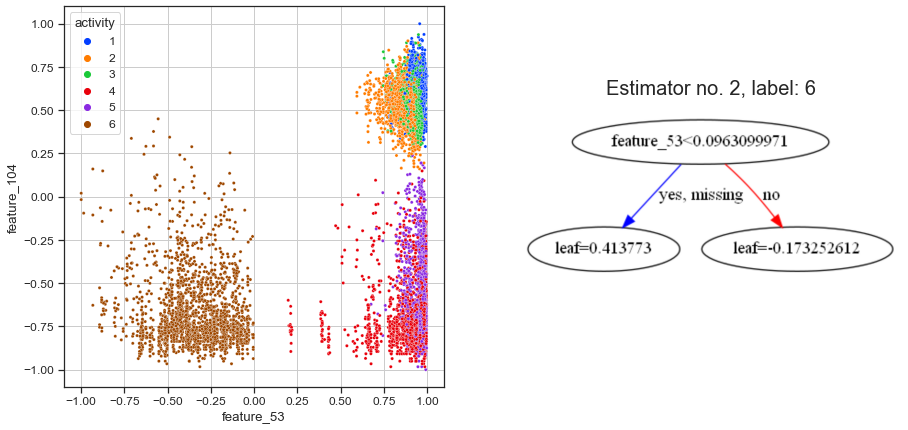

In [30]:
fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (15, 7))
sns.scatterplot(data=df, x='feature_53', y='feature_104', hue='activity', s=10, palette=sns.color_palette("bright")[:6], ax=axes[0])
axes[1].imshow(plt.imread("images/tree_11_only.png"))
axes[1].axis('off')
axes[1].set_title('Estimator no. 2, label: 6', fontsize=20, pad=20)
plt.show()

Zgadza się: ujemna wartość `feature_53` oznacza niższe (a tak naprawdę zerowe) prawdopodobieństwo wystąpienia klasy nr $6$.

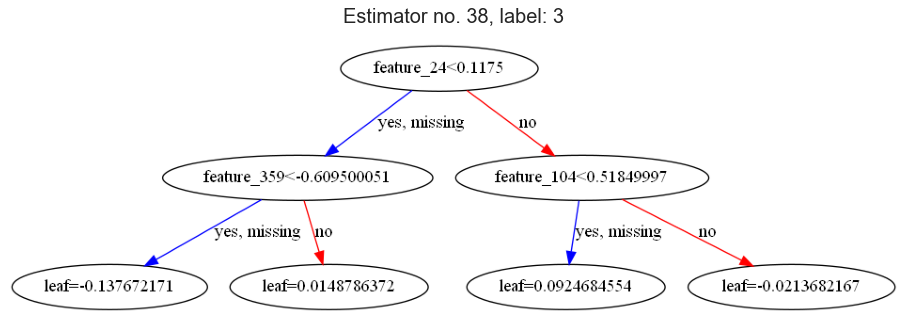

In [31]:
fig, ax = plt.subplots()
plot_tree(xgb, num_trees=224, ax = ax)
ax.set_title('Estimator no. 38, label: 3', fontsize=20, pad=20)
plt.show()

Tu również model pokrywa się z rzeczywistością - jak wynika z wcześniejszego wykresu, obiekty z klasy 3 rzeczywiście mają wartość `feature_104` niemal tak samo często większą, co mniejszą od 0.5

### Feature importance

In [32]:
xgb_importance = pd.DataFrame(dict(feature=X_train.columns,importance=xgb.feature_importances_)).\
    sort_values(by='importance', ascending=False, ignore_index=True)
xgb_importance

,feature,importance
0,feature_349,0.165320
1,feature_17,0.070103
2,feature_53,0.061643
3,feature_505,0.047197
4,feature_331,0.040052
...,...,...
556,feature_363,0.000000
557,feature_365,0.000000
558,feature_366,0.000000
559,feature_367,0.000000


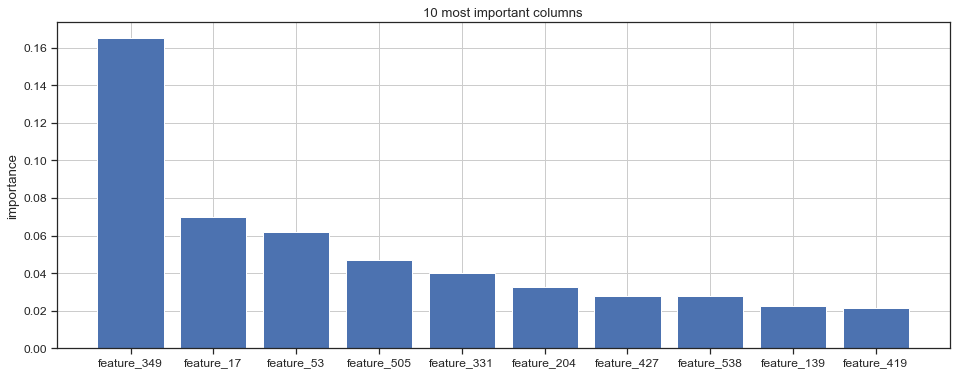

In [33]:
plt.bar(x = xgb_importance['feature'][:10], height = xgb_importance['importance'][:10])
plt.title('10 most important columns')
plt.ylabel('importance')
plt.show()

Zauważmy, że suma 103 największych współczynników przekracza 95%. Oznacza to, że tylko nieco ponad 100 kolumn (spośród ponad 500) odpowiada w 95% za finalną prognozę:

In [34]:
np.count_nonzero(xgb_importance.loc[:, 'importance':].cumsum() <= 0.95)

103

Niestety, na podstawie powyższego wskaźnika nie jesteśmy w stanie stwierdzić, która funkcjonalność zadecydowała o przydziale do konkretnej klasy. Bardziej szczegółowych danych w tym zakresie dostarcza nam pakiet `shap`.

### Feature importance - SHAP

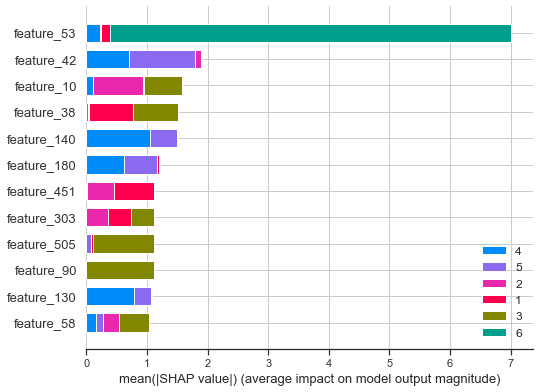

In [35]:
shap.summary_plot(shap.TreeExplainer(xgb).shap_values(X_test), X_test, class_names=np.arange(6) + 1, max_display=12)

Ponownie możemy odnotować np. ogromny wpływ zmiennej `feature_53` na fakt, czy obiekt należy, bądź nie, do klasy nr $6$.

## Dodatek - przycinanie outlierów
Niestety, nie odnotowaliśmy znaczącej poprawy. Jaka szkoda. 😢

--------------------------Zbiór treningowy-------------------------
                1       2       3       4       5       6  accuracy
precision  1.0000  1.0000  1.0000  0.9761  0.9838  1.0000    0.9929
recall     1.0000  1.0000  1.0000  0.9828  0.9775  1.0000    0.9929
f1-score   1.0000  1.0000  1.0000  0.9794  0.9807  1.0000    0.9929

---------------------------Zbiór testowy---------------------------
                1       2       3       4       5       6  accuracy
precision  0.9972  0.9908  1.0000  0.9649  0.9627  1.0000    0.9852
recall     0.9945  1.0000  0.9966  0.9571  0.9675  1.0000    0.9852
f1-score   0.9959  0.9954  0.9983  0.9610  0.9651  1.0000    0.9852



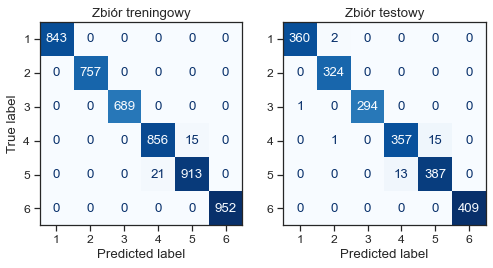

In [37]:
clf_with_outlier_cutter = make_pipeline(
    OutlierCutter(),
    LogisticRegression(penalty='l1', solver='liblinear', C=2.7)
).fit(X_train, y_train)
print_precision_recall_report(clf_with_outlier_cutter, X_train, y_train, X_test, y_test)

## Podsumowanie wyników
Ponieważ klasy docelowe są zbalansowane, metryka *accuracy* wydaje się być dobrym sposobem na porówywanie modeli. Porównywać będziemy głównie wynik na zbiorze walidacyjnym, specjalnie zostawionym na tą okazję.

In [38]:
models = [clf, svc, xgb, vot]
model_names = ['Logistic Regression', 'Linear SVC', 'XGBoost', 'Soft Voting']

datasets = [(X_train, y_train), (X_test, y_test), (X_val, y_val)]
dataset_names = ['Train', 'Test', 'Val']

rows = []

for model in models:
    row = []
    for X, y in datasets:
        y_pred = model.predict(X)
        score = accuracy_score(y, y_pred)
        row.append(score)
    rows.append(row)
    
summary = pd.DataFrame(rows, index=model_names, columns=dataset_names).sort_values(by='Val', ascending=False)

In [39]:
summary

,Train,Test,Val
XGBoost,1.000000,0.987517,0.986084
Soft Voting,0.997226,0.989367,0.985437
Linear SVC,0.990289,0.985206,0.980259
Logistic Regression,0.990091,0.984281,0.979288


#### Najlepszy model - XGBoost
Nawyższe wyniki na zbiorze walidacyjnym zdobył model XGBoost. 

Poniżej znajdują się jeszcze szczegółowe metryki zbiorze walidacyjnym.

In [40]:
y_val_pred = xgb.predict(X_val)

In [41]:
pd.DataFrame(
    classification_report(
        y_val, y_val_pred,
        output_dict = True
    )
).iloc[:-1, :-2]

,1,2,3,4,5,6,accuracy
precision,1.000000,0.989270,0.990521,0.964552,0.973592,1.0,0.986084
recall,0.996132,0.995680,0.990521,0.969981,0.966783,1.0,0.986084
f1-score,0.998062,0.992465,0.990521,0.967259,0.970175,1.0,0.986084


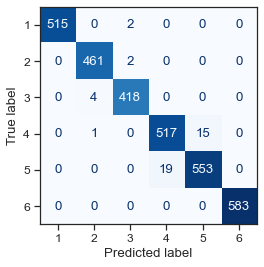

In [42]:
plt.figure(figsize=(4, 4))
conf_mx = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mx, display_labels=[1, 2, 3, 4, 5, 6])
disp.plot(colorbar=False, cmap=plt.cm.Blues, ax=plt.gca(), values_format='d')
plt.grid(False)